In [1]:
import scanpy as sc
import anndata as ad
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (4, 4)

In [2]:
adata = sc.read_h5ad("mcg_210505_4798x819_qc.h5ad") # read in data
mask = pd.read_parquet('mask005.parquet') # true means cov <5 so needs to be imputed

In [3]:
methyl_df = adata.to_df() # df of the methylation data
methyl_df = methyl_df[~mask] # apply Bool mask
methyl_df.isna().sum().sum() # total NaN's to impute

np.int64(13808)

In [4]:
cell_type = pd.read_csv("/u/project/cluo/heffel/BICAN3/Annotate/metadata_09122025.csv.gz").set_index("ID")
cell_type.head(1)

,newL1,newL2,newL3,fine_age_groups,age_groups,float_age,Interaction_count,updated_region,mCG/CG_chrL,mCH/CH_chrL,...,pairs_enzymeless_intra1kb,pairs_enzymeless_intra10kb,pairs_enzymeless_intra20kb,pairs_enzymeless_inter,pairs_dup_rate,high_coverage_pairs,allc_input_genome_coverage_dup,allc_input_genome_coverage_dedup,allc_input_mapped_bp_dup,allc_input_mapped_bp_dedup
ID,,,,,,,,,,,,,,,,,,,,,
20210111-1863-preAb-PFC-B12_A1,Exc,UL,L1-3-CUX2,adult,adult,31.0,101825.0,DFC,NaN,NaN,...,5183.0,4742.0,4499.0,1399.0,0.377175,81.0,44221255.0,44221255.0,45085203.0,45085203.0


## randomly mask 5% of good values to compare to generated/imputed data

In [5]:
# mask 5% of good data with true values
np.random.seed(42)
dropout_mask = (np.random.rand(*methyl_df.shape) < 0.05) & ~mask # create Bool mask w shape of data; 5% randomly set to True

In [6]:
# apply the mask
methyl_df = methyl_df[~dropout_mask]

In [7]:
methyl_df.isna().sum().sum()

np.int64(209381)

In [8]:
# save mask
import pyarrow
dropout_mask.to_parquet('dropout_mask.parquet')

## zero imputation

In [9]:
zero_imp = methyl_df.fillna(0) # impute low coverage with 0's

In [10]:
# create AnnData obj
zdata = ad.AnnData(X=zero_imp)

zdata.obs = adata.obs.copy()
zdata.var = adata.var.copy()

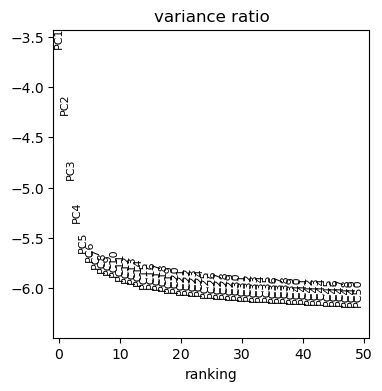

In [11]:
# z-score
sc.pp.scale(zdata)

# pca
sc.tl.pca(zdata)
sc.pl.pca_variance_ratio(zdata, n_pcs=50, log=True)

zero imputation


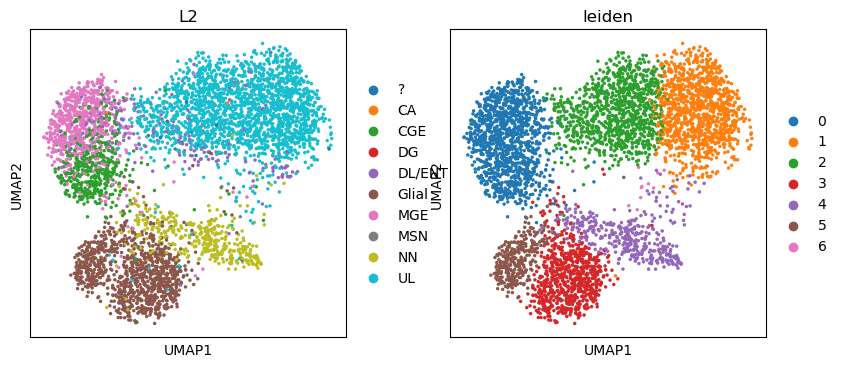

In [12]:
# umap
sc.pp.neighbors(zdata)
sc.tl.leiden(zdata)
sc.tl.umap(zdata)
zdata.obs["L2"] = cell_type["newL2"]

print("zero imputation")
sc.pl.umap(zdata, color=["L2", "leiden"])

In [13]:
# force values to [-1, 1]
X = zdata.X
zdata.X = 2 * (X - X.min()) / (X.max() - X.min()) -1

In [14]:
zdata.write_h5ad("mcg_210505_4798x819_zero_imputation.h5ad")

## mean imputation

In [15]:
# create dataframe of mean for each gene
gene_means = methyl_df.mean() # series of gene meansskipna=True by default
gene_means.head(1)

geneslop2k
PRKCZ    0.71139
dtype: float64

In [16]:
# for each feature (column), replace any NA value with the value corresponding in gene_means
mean_imp = methyl_df.fillna(gene_means)

In [17]:
mdata = ad.AnnData(X=mean_imp)

mdata.obs = adata.obs.copy()
mdata.var = adata.var.copy()

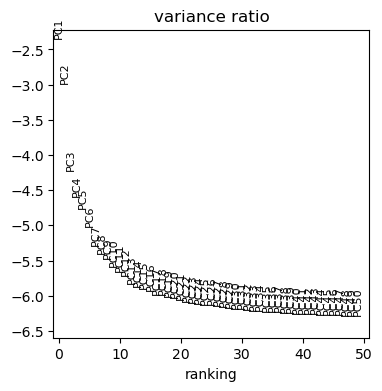

In [18]:
# z-score
sc.pp.scale(mdata)

# pca
sc.tl.pca(mdata)
sc.pl.pca_variance_ratio(mdata, n_pcs=50, log=True)

mean imputation


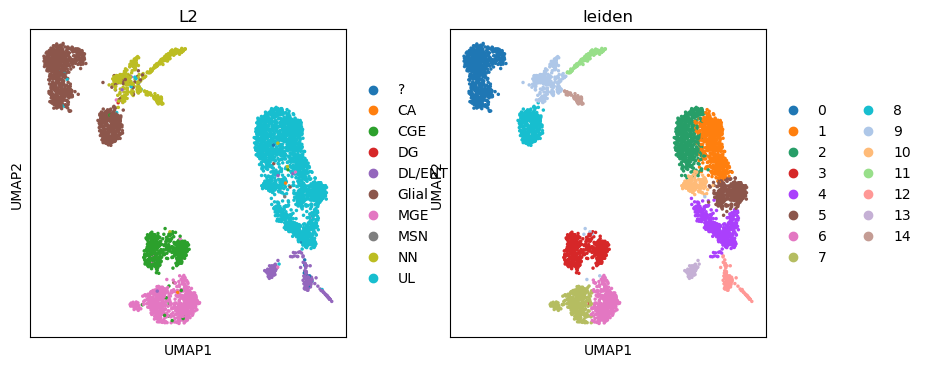

In [19]:
# umap
sc.pp.neighbors(mdata)
sc.tl.leiden(mdata)
sc.tl.umap(mdata)
mdata.obs["L2"] = cell_type["newL2"]

print("mean imputation")
sc.pl.umap(mdata, color=["L2", "leiden"])

In [20]:
# force values to [-1, 1]
X = mdata.X
mdata.X = 2 * (X - X.min()) / (X.max() - X.min()) -1

In [21]:
mdata.write_h5ad("mcg_210505_4798x819_mean_imputation.h5ad")

## k nearest neighbors mean imputation

In [22]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=16, metric="euclidean")

In [23]:
# fit model on pca data from the mean imputation
knn.fit(pd.DataFrame(mdata.obsm["X_pca"])) 

NearestNeighbors(metric='euclidean', n_neighbors=16)

In [24]:
# find the 15 nearest neighbors index for each cell
distances, indices = knn.kneighbors(pd.DataFrame(zdata.obsm["X_pca"]))
knn_df = pd.DataFrame(indices, index=adata.obs.index)
knn_df = knn_df.iloc[:, 1:] # remove self as neighbor
knn_df.head(1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
20210505-UMB5577-preAb-PFC-A09-L1_A1,749,626,813,517,2422,3488,3796,2843,459,2664,4476,682,1171,2547,1153


In [25]:
# calculate nearest neighbor means for each cell for each genomic position
knn_means = knn_df.apply(
    lambda row: adata.to_df().iloc[row.values].mean(axis=0),
    axis=1
)
knn_means.head(1)

geneslop2k,PRKCZ,ENSG00000157933.11,PRDM16,ENSG00000162591.17,AJAP1,NPHP4,ENSG00000097021.21,ENSG00000171735.20,ENSG00000142599.20,CASZ1,...,EFCAB6,PARVB,PRR5-ARHGAP8,PHF21B,CELSR1,GRAMD4,TBC1D22A,ENSG00000224271.8,TAFA5,ENSG00000188511.14
20210505-UMB5577-preAb-PFC-A09-L1_A1,0.836913,0.468404,0.862858,0.925586,0.78542,0.847829,0.881792,0.880925,0.772361,0.813904,...,0.872801,0.899793,0.906668,0.884884,0.92764,0.821366,0.912206,0.911031,0.837083,0.927834


In [26]:
knn_imp = methyl_df.fillna(knn_means)

In [27]:
kdata = ad.AnnData(X=knn_imp)

kdata.obs = adata.obs.copy()
kdata.var = adata.var.copy()

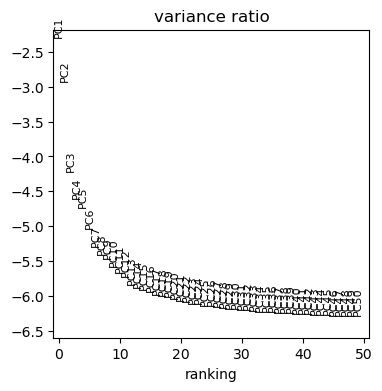

In [28]:
# z-score
sc.pp.scale(kdata)

# pca
sc.tl.pca(kdata)
sc.pl.pca_variance_ratio(kdata, n_pcs=50, log=True)

knn imputation


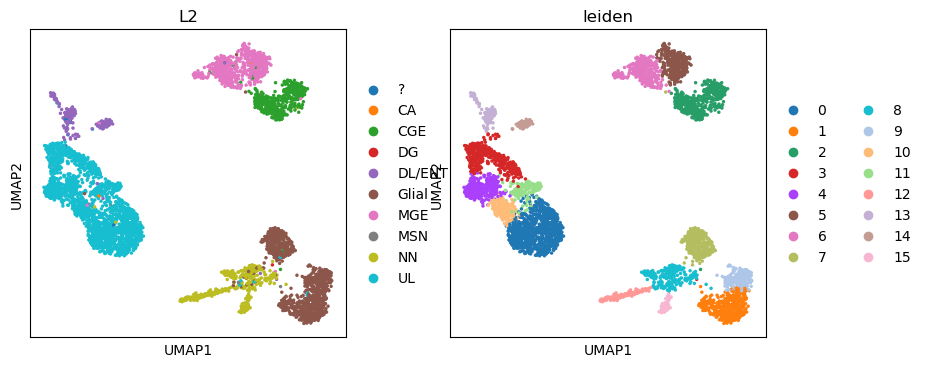

In [29]:
# umap
sc.pp.neighbors(kdata)
sc.tl.leiden(kdata)
sc.tl.umap(kdata)
kdata.obs["L2"] = cell_type["newL2"]

print("knn imputation")
sc.pl.umap(kdata, color=["L2", "leiden"])

In [30]:
# force values back to [-1, 1]
X = kdata.X
kdata.X = 2 * (X - X.min()) / (X.max() - X.min()) -1

In [31]:
kdata.write_h5ad("mcg_210505_4798x819_knn_imputation.h5ad")